<h1>MBA Latency Charts IPv4 </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>
<br>
<h7>3/24/22</h7>

In [2]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [4]:
# %%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

Executed


<h4> BigQuery SQL Queries for Latency

In [31]:
peakHourLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, 
    avg(rtt_avg/1000) as avgRTT, 
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
WHERE (EXTRACT(HOUR FROM lat.dtime) >= 19) AND (EXTRACT(HOUR FROM lat.dtime) <=23) 
GROUP BY mt.ISP, mt.Technology
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Technology
"""


fullDayLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, 
    avg(rtt_avg/1000) as avgRTT, 
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
GROUP BY mt.ISP, mt.Technology
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Technology
"""

# creating dataframes

peakHourLatency = client.query(peakHourLatencySQL).to_dataframe()
fullDayLatency = client.query(fullDayLatencySQL).to_dataframe()
print("Executed")

Executed


<h3> Latency Charts by ISP and Technology

<hr>

In [32]:
scatterTemp = pd.DataFrame()
scatterTemp['x'] = peakHourLatency.index
scatterTemp['isp'] = peakHourLatency['isp']
scatterTemp['tech'] = peakHourLatency['tech']
scatterTemp['totalBoxes'] = peakHourLatency['totalBoxes']
scatterTemp['avgRTT'] = peakHourLatency['avgRTT']
scatterTemp['medianRTT'] = peakHourLatency['medianRTT']
scatterTemp['slowestTwentyPctRTT'] = peakHourLatency['slowestTwentyPctRTT']
scatterTemp['slowest5PctRTT'] = peakHourLatency['slowest5PctRTT']
scatterTemp['fastest5PctRTT'] = peakHourLatency['fastest5PctRTT']
ispTech =  list(scatterTemp['isp'] +"\n"+ scatterTemp['tech'])
scatterTemp['ispTech'] = ispTech
scatterTemp

,x,isp,tech,totalBoxes,avgRTT,medianRTT,slowestTwentyPctRTT,slowest5PctRTT,fastest5PctRTT,ispTech
0,0,Comcast,Cable,449,16.448045,14.848,19.775,28.857,10.022,Comcast\nCable
1,1,Mediacom,Cable,183,24.500787,24.292,30.677,38.509,14.513,Mediacom\nCable
2,2,Charter,Cable,313,25.845375,24.498,32.553,43.727,12.752,Charter\nCable
3,3,Optimum,Cable,156,12.192631,11.740,13.397,16.515,9.162,Optimum\nCable
4,4,Cox,Cable,207,19.435085,18.518,23.923,32.229,10.274,Cox\nCable
5,5,CenturyLink,DSL,694,35.668099,31.995,46.256,68.001,11.888,CenturyLink\nDSL
6,6,Frontier,DSL,220,25.397268,21.195,30.961,50.159,10.141,Frontier\nDSL
7,7,Windstream,DSL,322,29.377097,26.729,35.691,51.107,16.029,Windstream\nDSL
8,8,Cincinnati Bell,DSL,141,28.482411,25.718,32.454,53.776,13.755,Cincinnati Bell\nDSL
9,9,Verizon DSL,DSL,37,42.964120,35.024,49.476,79.867,12.923,Verizon DSL\nDSL


Text(0.5, 1.0, "Select ISPs' Peak Hour Latency \n *Average, Median, 20th Percentile, 95% Consistency, and 5th Percentile*")

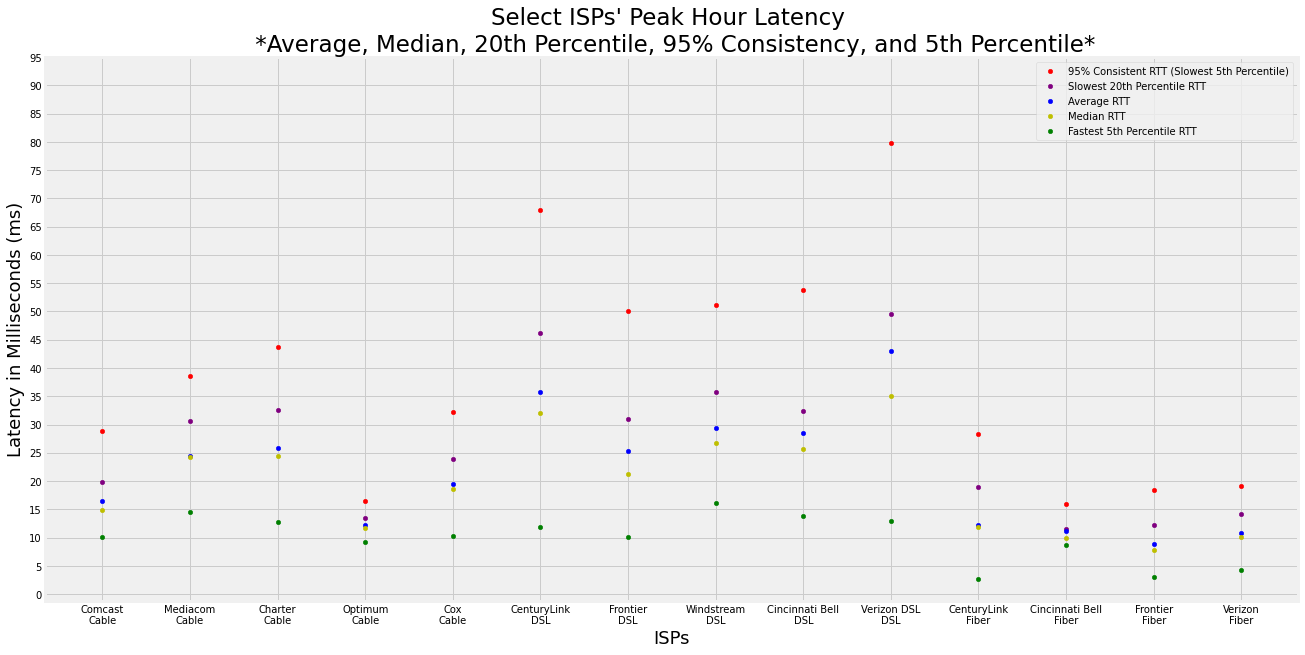

In [33]:
plt.rcParams["figure.figsize"] = [20, 10]



ax1 = scatterTemp.plot(kind='scatter', x='ispTech', y='slowest5PctRTT', color='r', label = '95% Consistent RTT (Slowest 5th Percentile)')   

ax2 = scatterTemp.plot(kind='scatter', x='ispTech', y='slowestTwentyPctRTT', color='purple', label = 'Slowest 20th Percentile RTT', ax=ax1)

ax3 = scatterTemp.plot(kind='scatter', x='ispTech', y='avgRTT', color='b', label = 'Average RTT', ax=ax1)

ax4 = scatterTemp.plot(kind='scatter', x='ispTech', y='medianRTT', color='y', label = 'Median RTT', ax=ax1)

ax5 = scatterTemp.plot(kind='scatter', x='ispTech', y='fastest5PctRTT', color='g',label = 'Fastest 5th Percentile RTT', ax=ax1)



plt.yticks(np.arange(0, 100, 5))

# plt.xticks(np.arange(0, 80, 1), rotation = 90)
plt.xticks(np.arange(0, len(scatterTemp), 1))

ax1.set_xlabel('ISPs', fontsize = 18)
ax1.set_ylabel('Latency in Milliseconds (ms)', fontsize = 18)
ax1.set_title("Select ISPs' Peak Hour Latency \n *Average, Median, 20th Percentile, 95% Consistency, and 5th Percentile*", fontsize=23)


In [34]:
peakHourLatency

,isp,tech,avgRTT,medianRTT,slowestTwentyPctRTT,slowest5PctRTT,fastest5PctRTT,totalBoxes
0,Comcast,Cable,16.448045,14.848,19.775,28.857,10.022,449
1,Mediacom,Cable,24.500787,24.292,30.677,38.509,14.513,183
2,Charter,Cable,25.845375,24.498,32.553,43.727,12.752,313
3,Optimum,Cable,12.192631,11.740,13.397,16.515,9.162,156
4,Cox,Cable,19.435085,18.518,23.923,32.229,10.274,207
5,CenturyLink,DSL,35.668099,31.995,46.256,68.001,11.888,694
6,Frontier,DSL,25.397268,21.195,30.961,50.159,10.141,220
7,Windstream,DSL,29.377097,26.729,35.691,51.107,16.029,322
8,Cincinnati Bell,DSL,28.482411,25.718,32.454,53.776,13.755,141
9,Verizon DSL,DSL,42.964120,35.024,49.476,79.867,12.923,37


**Chart below used in REPLY TO COMMENT**

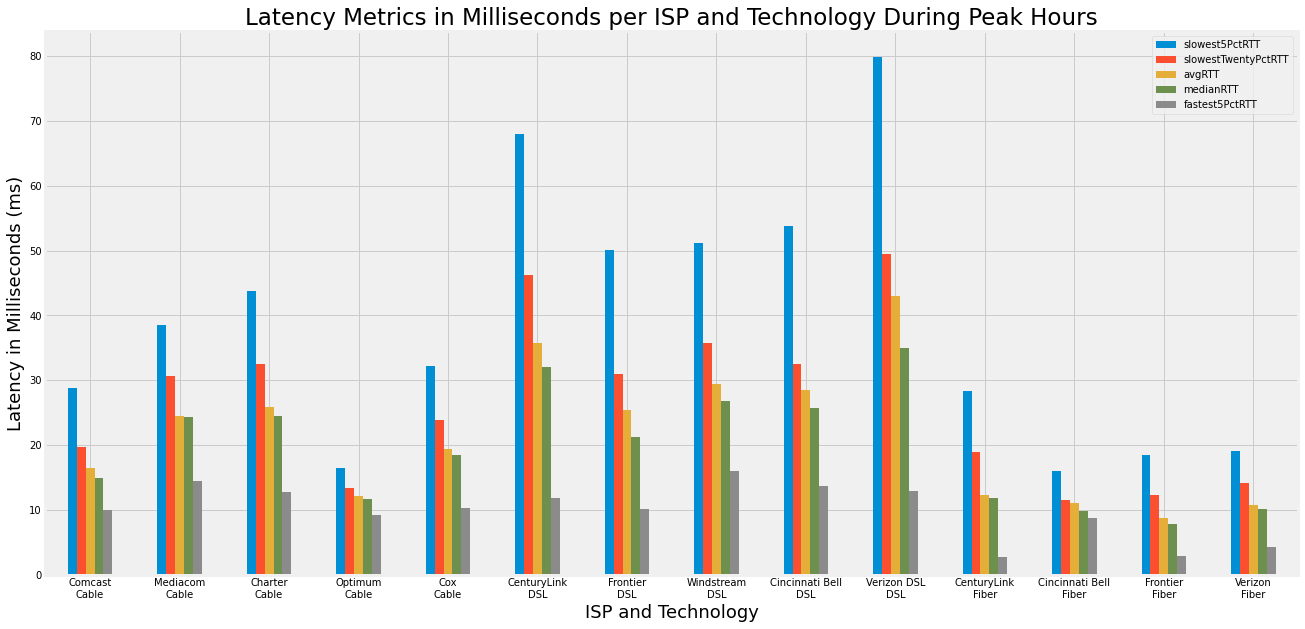

In [37]:
chartData = peakHourLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech



ax = chartData.plot(x = "ispTech", y = ['slowest5PctRTT', 'slowestTwentyPctRTT','avgRTT', 'medianRTT', 'fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('ISP and Technology',fontsize=18)
ax.set_ylabel('Latency in Milliseconds (ms)',fontsize=18)
ax.set_title('Latency Metrics in Milliseconds per ISP and Technology During Peak Hours', fontsize=23)


plt.show()

In [19]:
fullDayLatency = fullDayLatency.drop(index = 10)
fullDayLatency

,isp,tech,avgRTT,medianRTT,slowestTwentyPctRTT,slowest5PctRTT,fastest5PctRTT,totalBoxes
0,Comcast,Cable,16.142637,14.586,19.457,28.428,9.879,450
1,Mediacom,Cable,24.063479,24.026,30.226,37.452,14.307,184
2,Charter,Cable,25.342937,24.065,32.118,42.988,12.459,314
3,Cox,Cable,19.113731,18.181,23.512,31.399,10.186,208
4,Optimum,Cable,11.995907,11.525,13.074,16.143,9.076,156
5,CenturyLink,DSL,34.974093,31.850,45.486,66.084,11.840,699
6,Frontier,DSL,23.891635,20.563,29.711,45.225,9.950,223
7,Windstream,DSL,28.428832,26.319,34.339,47.815,15.997,322
8,Cincinnati Bell,DSL,28.262262,25.662,32.293,53.479,13.793,141
9,Verizon DSL,DSL,40.225237,34.952,49.852,71.618,13.088,37


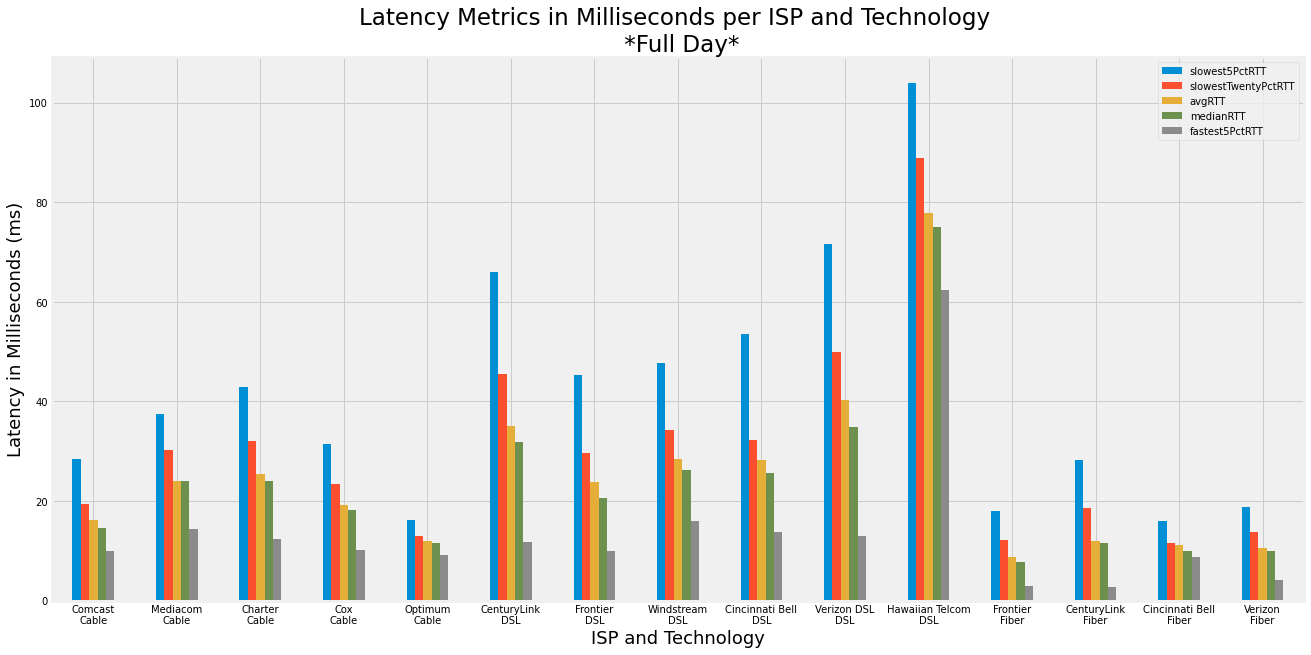

In [38]:
chartData = fullDayLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech




ax = chartData.plot(x = "ispTech", y = ['slowest5PctRTT', 'slowestTwentyPctRTT','avgRTT', 'medianRTT', 'fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('ISP and Technology',fontsize=18)
ax.set_ylabel('Latency in Milliseconds (ms)',fontsize=18)
ax.set_title('Latency Metrics in Milliseconds per ISP and Technology \n *Full Day*', fontsize=23)


plt.show()

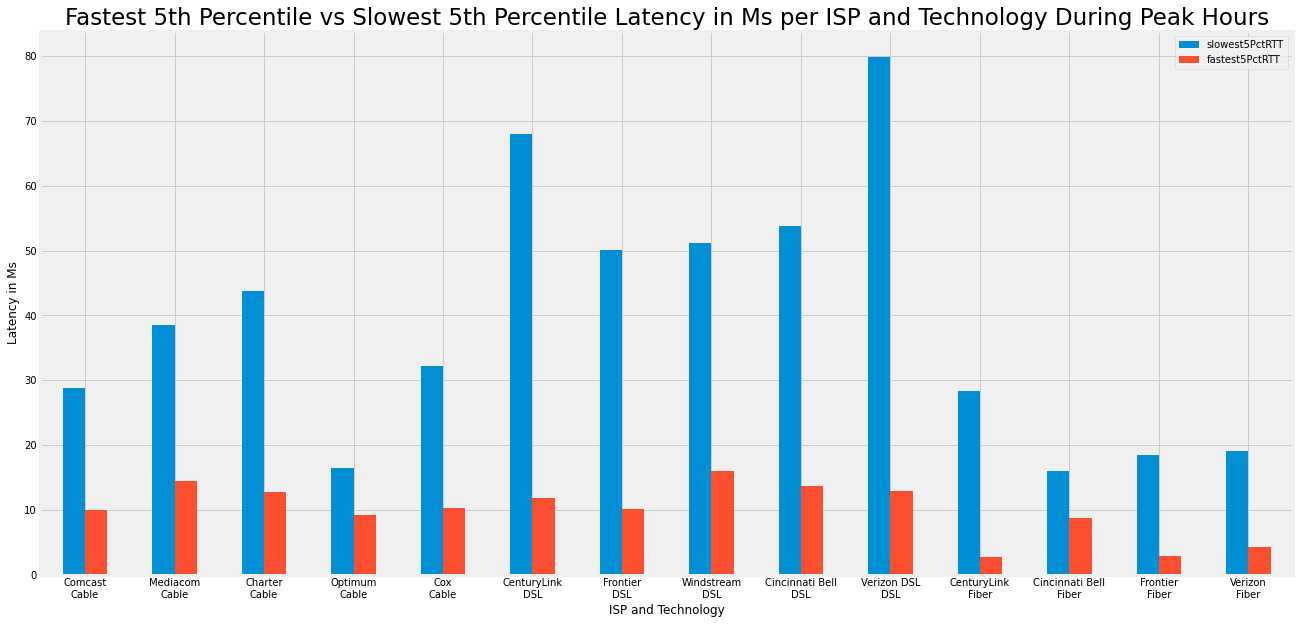

In [21]:
chartData = peakHourLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech



ax = chartData.plot(x = "ispTech", y = ['slowest5PctRTT','fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('ISP and Technology')
ax.set_ylabel('Latency in Ms')
ax.set_title('Fastest 5th Percentile vs Slowest 5th Percentile Latency in Ms per ISP and Technology During Peak Hours', fontsize=23)


plt.show()

<hr>

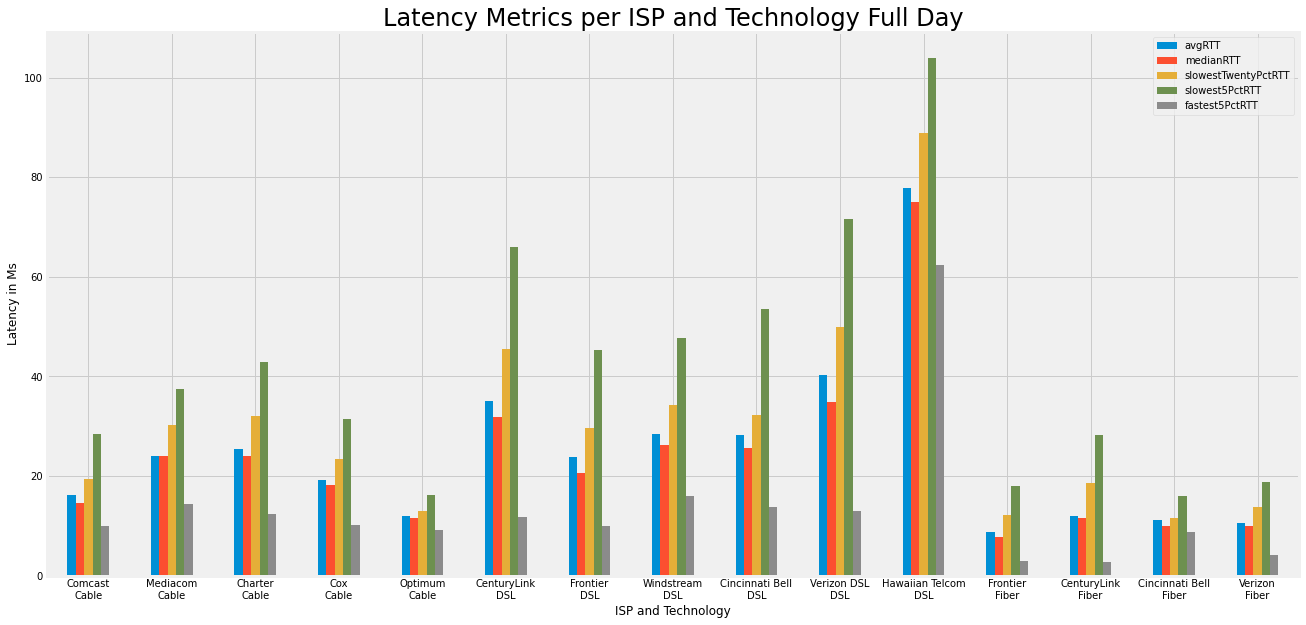

In [19]:
chartData = fullDayLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech




ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowestTwentyPctRTT','slowest5PctRTT', 'fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('ISP and Technology')
ax.set_ylabel('Latency in Ms')
ax.set_title('Latency Metrics per ISP and Technology Full Day', fontsize=24)


plt.show()

<hr>

<h4> BigQuery SQL Queries for Latency by tier

In [20]:
peakHourTierLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, mt.Download as downloadTier,
    avg(rtt_avg/1000) as avgRTT, 
    min(rtt_avg/1000) as minAvg,
    avg(rtt_min/1000) as min,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
WHERE (EXTRACT(HOUR FROM lat.dtime) >= 19) AND (EXTRACT(HOUR FROM lat.dtime) <=23) 
GROUP BY mt.ISP, mt.Technology, mt.Download
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Download, mt.Technology
"""

fullDayTierLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, mt.Download as downloadTier,
    avg(rtt_avg/1000) as avgRTT, 
    min(rtt_avg/1000) as minAvg,
    avg(rtt_min/1000) as min,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
GROUP BY mt.ISP, mt.Technology, mt.Download
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Download, mt.Technology
"""

peakHourTierLatency = client.query(peakHourTierLatencySQL).to_dataframe()
fullDayTierLatency = client.query(fullDayTierLatencySQL).to_dataframe()
print("Executed")


Executed


<h4> Python functions for normalzing dataframes to tiers

In [ ]:
def dfNormalizer(df):
    
    ispTech =  df['downloadTier'].astype(str) +"\n"+ df['isp'] +"\n"+ df['tech']      
    tier = df['downloadTier']
    isp = df['isp']
    tech = df['tech']
    avgRTT = df['avgRTT']
    medianRTT = df['medianRTT']
    slowTwentyPctRTT = df['slowestTwentyPctRTT']
    slowFivePctRTT = df['slowest5PctRTT']
    fast5PctRTT = df['fastest5PctRTT']

    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avgRTT=avgRTT, 
                               medianRTT=medianRTT, slowTwentyPctRTT=slowTwentyPctRTT,
                               slowFivePctRTT=slowFivePctRTT, fast5PctRTT=fast5PctRTT))
    return result



In [22]:
# DSL ISPs: Windstream + Centurylink
# Cable ISPs: Comcast, Optimum, Mediacom
# Fiber ISPs: Frontier, Verizon 

# Normalized Dataframes:
peakLatencyChart = dfNormalizer(peakHourTierLatency)
fullDayLatencyChart = dfNormalizer(fullDayTierLatency)


# Peak latency DSL 
peakLatencyDSL = peakLatencyChart.where(peakLatencyChart.tech == "DSL").dropna()
peakLatencyDSL = peakLatencyDSL[(peakLatencyDSL['isp'] == "Windstream") |(peakLatencyDSL['isp'] == "CenturyLink")]

# Peak Latency Cable
peakLatencyCable = peakLatencyChart.where(peakLatencyChart.tech == "Cable").dropna()
peakLatencyCable = peakLatencyCable[(peakLatencyCable['isp'] =='Comcast') | (peakLatencyCable['isp'] =='Optimum') | 
                        (peakLatencyCable['isp'] =='Mediacom')]
# Peak Latency Fiber
peakLatencyFiber = peakLatencyChart.where(peakLatencyChart.tech == "Fiber").dropna()
peakLatencyFiber = peakLatencyFiber[(peakLatencyFiber['isp'] =='Frontier') | (peakLatencyFiber['isp'] =='Verizon')]


# Full-day Latency DSL
fullDayLatencyDSL = fullDayLatencyChart.where(fullDayLatencyChart.tech == "DSL").dropna()
fullDayLatencyDSL = fullDayLatencyDSL[(fullDayLatencyDSL['isp'] == "Windstream") |(fullDayLatencyDSL['isp'] == "CenturyLink")]


# Full-day Latency Cable
fullDayLatencyCable = fullDayLatencyChart.where(fullDayLatencyChart.tech == "Cable").dropna()
fullDayLatencyCable = fullDayLatencyCable[(fullDayLatencyCable['isp'] =='Comcast') | (fullDayLatencyCable['isp'] =='Optimum') | 
                        (fullDayLatencyCable['isp'] =='Mediacom')]

# Full-day Latency Fiber
fullDayLatencyFiber = fullDayLatencyChart.where(fullDayLatencyChart.tech == "Fiber").dropna()
fullDayLatencyFiber = fullDayLatencyFiber[(fullDayLatencyFiber['isp'] =='Frontier') | (fullDayLatencyFiber['isp'] =='Verizon')]





<h3> Latency Charts by ISP, Technology, and Download Tier

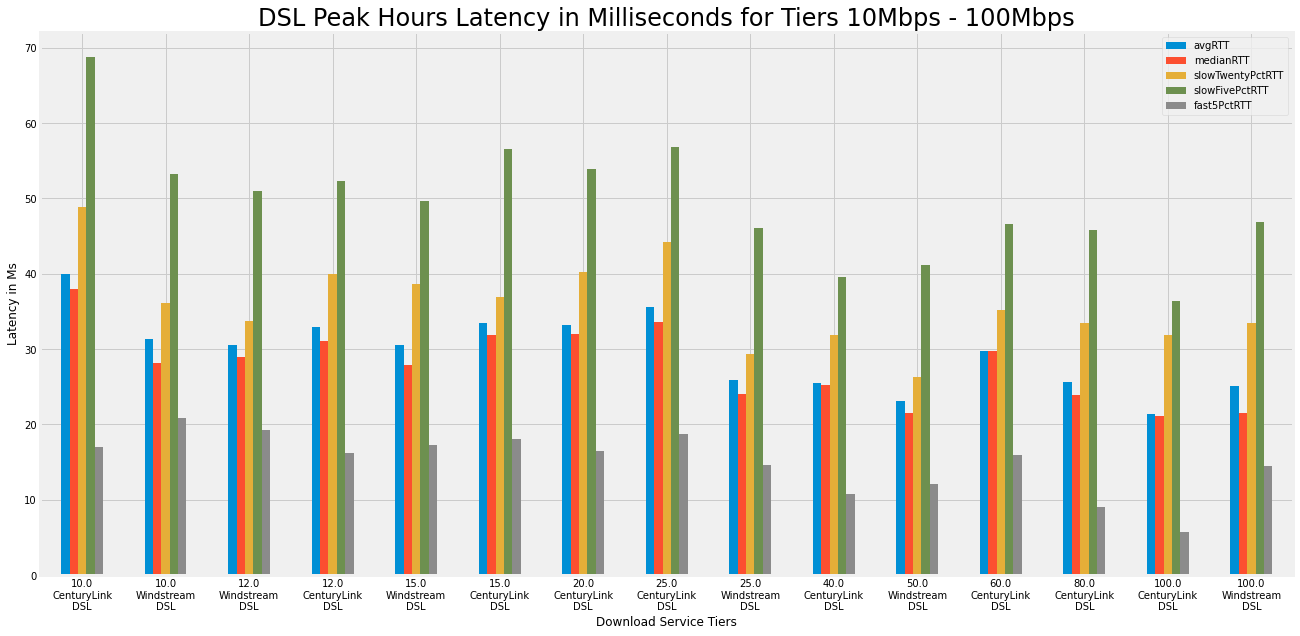

In [23]:
chartData = peakLatencyDSL
chartData = chartData[chartData.tier >= 10]


ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('DSL Peak Hours Latency in Milliseconds for Tiers 10Mbps - 100Mbps', fontsize=24)


plt.show()

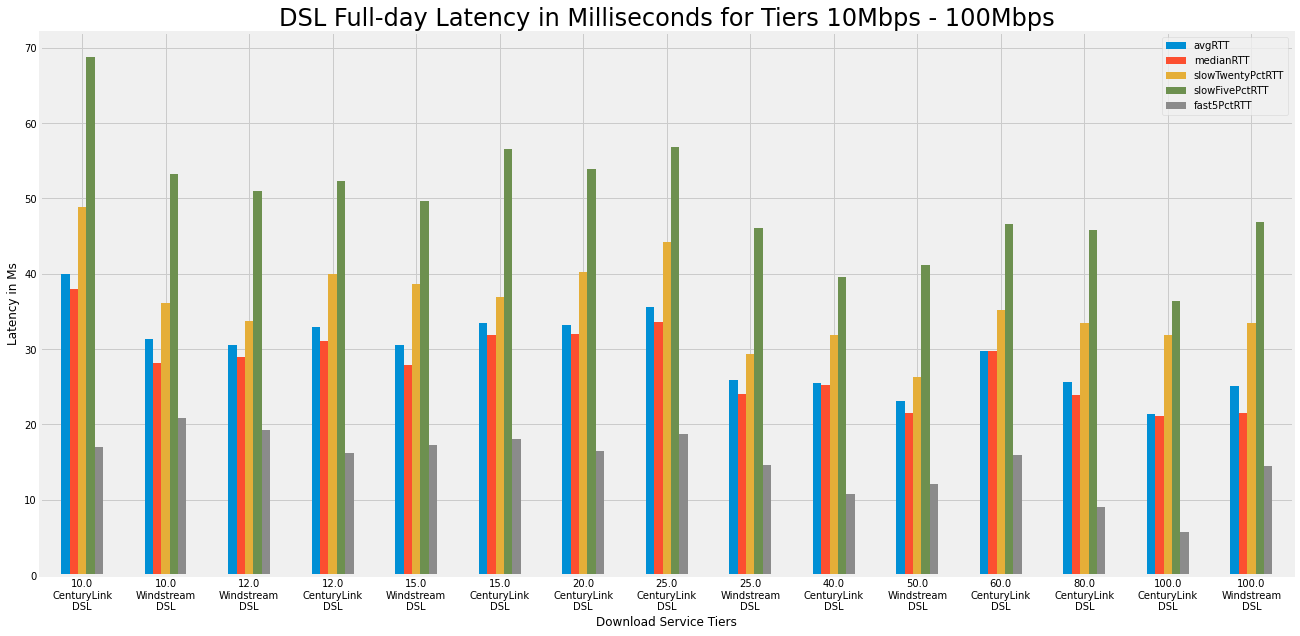

In [24]:
chartData = peakLatencyDSL
chartData = chartData[chartData.tier >= 10]


ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('DSL Full-day Latency in Milliseconds for Tiers 10Mbps - 100Mbps', fontsize=24)


plt.show()

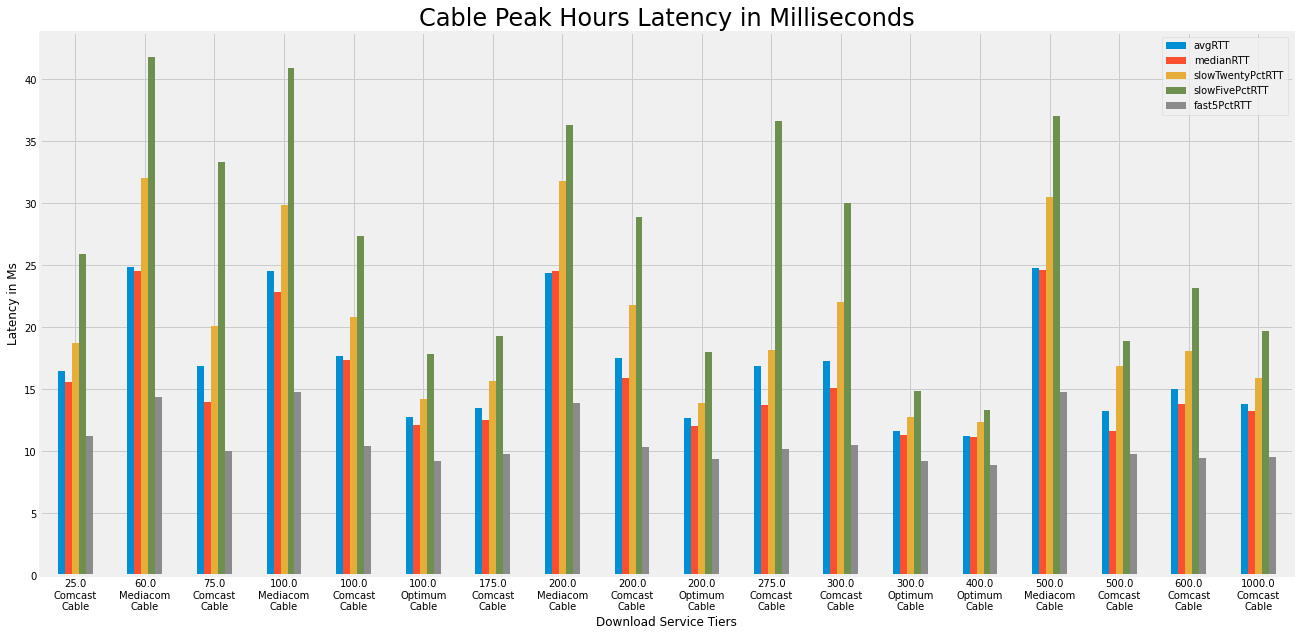

In [25]:
chartData = peakLatencyCable

ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('Cable Peak Hours Latency in Milliseconds', fontsize=24)


plt.show()

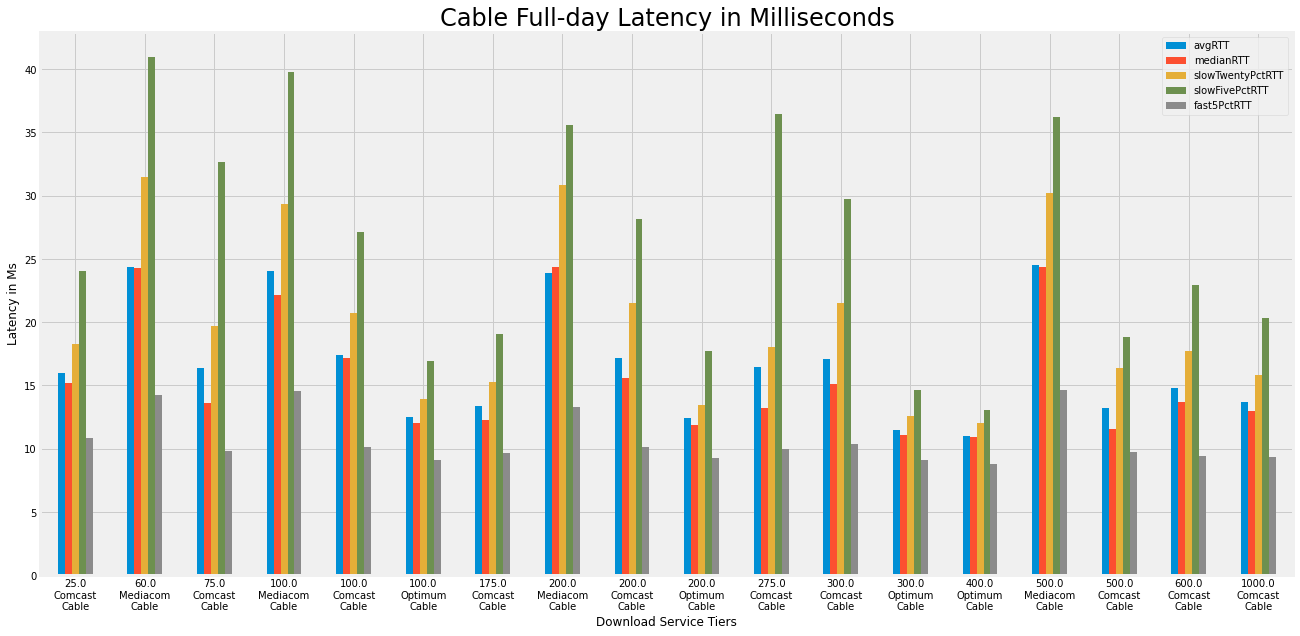

In [26]:
chartData = fullDayLatencyCable





ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('Cable Full-day Latency in Milliseconds', fontsize=24)


plt.show()

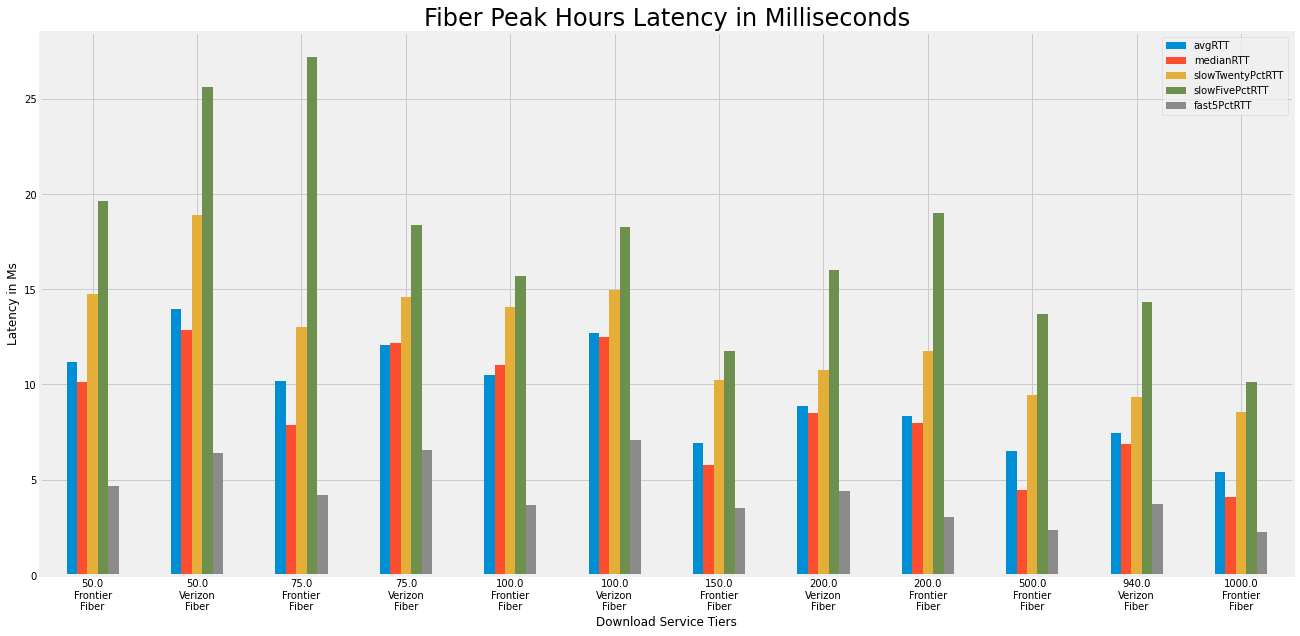

In [27]:
chartData = peakLatencyFiber



ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('Fiber Peak Hours Latency in Milliseconds', fontsize=24)


plt.show()

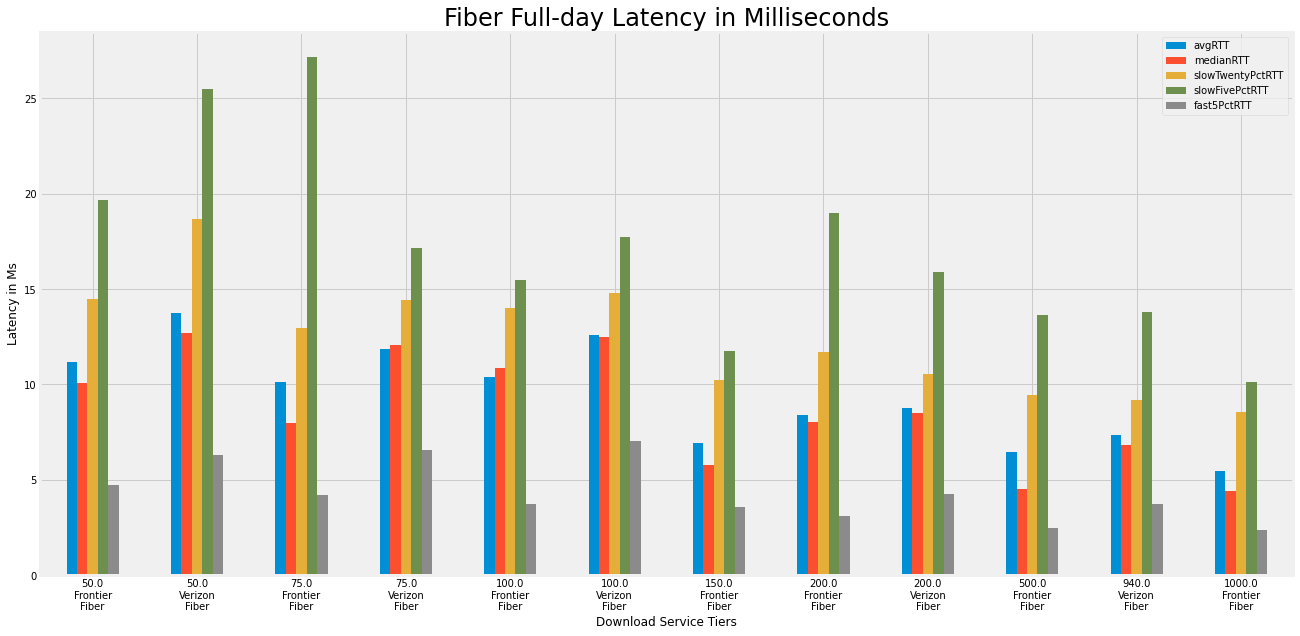

In [28]:
chartData = fullDayLatencyFiber



ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in Ms')
ax.set_title('Fiber Full-day Latency in Milliseconds', fontsize=24)


plt.show()